In [2]:
BASE_PATH = "./techLargCapStock"

STOCK_SYMBOLS = [
    "RDDT",
    "IOT",
    "NOW",
    "APH",
    "YMM",
    "DELL",
    "VEEV",
    "PSTG",
    "TEL",
    "UI",
]

In [3]:
import pandas as pd
import os


def read_stock_csv(base_path):
    stock_data = {}
    for filename in os.listdir(base_path):
        if filename.endswith(".csv"):
            stock_symbol = filename[:-4]  # Extract stock symbol from filename
            file_path = os.path.join(base_path, filename)
            try:
                df = pd.read_csv(file_path)

                # Clean and convert numerical columns
                for col in ["Close/Last", "Open", "High", "Low"]:
                    # Remove dollar signs and convert to numeric, replacing errors with NaN
                    df[col] = pd.to_numeric(
                        df[col].str.replace("$", "", regex=False), errors="coerce"
                    ).fillna(0)

                # Convert 'Volume' to integer, replacing errors with NaN and then 0
                df["Volume"] = (
                    pd.to_numeric(df["Volume"], errors="coerce").fillna(0).astype(int)
                )

                # Convert 'Date' to datetime objects, replacing errors with a default date
                df["Date"] = pd.to_datetime(df["Date"], errors="coerce").fillna(
                    pd.to_datetime("1970-01-01")
                )

                # Rename columns to lowercase and 'Close/Last' to 'Close'
                df.columns = df.columns.str.lower()
                df = df.rename(columns={"close/last": "close"})

                # Sort by date in descending order (most recent first)
                df = df.sort_values(by="date", ascending=False).reset_index(drop=True)

                stock_data[stock_symbol] = df

            except Exception as e:
                print(f"Error processing file '{filename}': {e}")

    return stock_data


stock_dfs = read_stock_csv(BASE_PATH)

In [4]:
stock_dfs.keys()

dict_keys(['APH', 'DELL', 'IOT', 'NOW', 'PSTG', 'RDDT', 'TEL', 'UI', 'VEEVA', 'YMM'])

In [5]:
for i in stock_dfs.keys():
    print(i, len(stock_dfs[i]))

APH 2515
DELL 1592
IOT 840
NOW 2515
PSTG 2399
RDDT 272
TEL 2515
UI 2515
VEEVA 2515
YMM 962


In [6]:
import pandas as pd

def pad_stock_dataframes_outer_join(stock_data, fill_value=0):
    """
    Pads the stock DataFrames so they all have the same set of dates,
    effectively performing an "outer join" on the 'date' column.
    Missing values for dates not present in a specific DataFrame are filled
    with the provided fill_value for numerical columns and NaN for others.

    Args:
        stock_data (dict): A dictionary where keys are stock symbols and values are
                           Pandas DataFrames with a 'date' column.
        fill_value (any, optional): The value to fill missing numerical data. Defaults to 0.

    Returns:
        dict: A dictionary with the padded DataFrames.
    """

    all_dates = set()
    for df in stock_data.values():
        if 'date' in df.columns:
            all_dates.update(df['date'])

    if not all_dates:
        print("Warning: No date information found in any DataFrame. Returning original data.")
        return stock_data

    all_dates_df = pd.DataFrame({'date': sorted(list(all_dates))})
    padded_stock_data = {}

    for symbol, df in stock_data.items():
        if 'date' in df.columns:
            merged_df = pd.merge(all_dates_df, df, on='date', how='left')
            # Fill NaN values in numerical columns with fill_value
            for col in merged_df.columns:
                if col != 'date' and pd.api.types.is_numeric_dtype(merged_df[col]):
                    merged_df[col] = merged_df[col].fillna(fill_value)
            padded_stock_data[symbol] = merged_df
        else:
            print(f"Warning: DataFrame for {symbol} is missing 'date' column and will not be padded.")
            padded_stock_data[symbol] = df.copy()

    return padded_stock_data

padded_stock_data  = pad_stock_dataframes_outer_join(stock_dfs, fill_value=0)

In [7]:
def calculate_moving_average(stock_data, m):
    """
    Calculates the m-day moving average of the 'close' price for all
    DataFrames in the input dictionary and adds it as a new column.

    Args:
        stock_data (dict): A dictionary where keys are stock symbols and values are
                           Pandas DataFrames with a 'close' column (lowercase).
        m (int): The number of days to use for the moving average calculation.

    Returns:
        dict: A dictionary containing the modified DataFrames, each with the
              added moving average column ('close_ma_{m}').
    """
    updated_stock_data = {}
    for symbol, df in stock_data.items():
        new_column_name = f'close_ma_{m}'
        df[new_column_name] = df['close'].rolling(window=m).mean()
        # Fill NaN values in the moving average column with 0
        df[new_column_name] = df[new_column_name].fillna(0)
        updated_stock_data[symbol] = df

    return updated_stock_data

ma5_padded_stock_dfs = calculate_moving_average(padded_stock_data, 14)

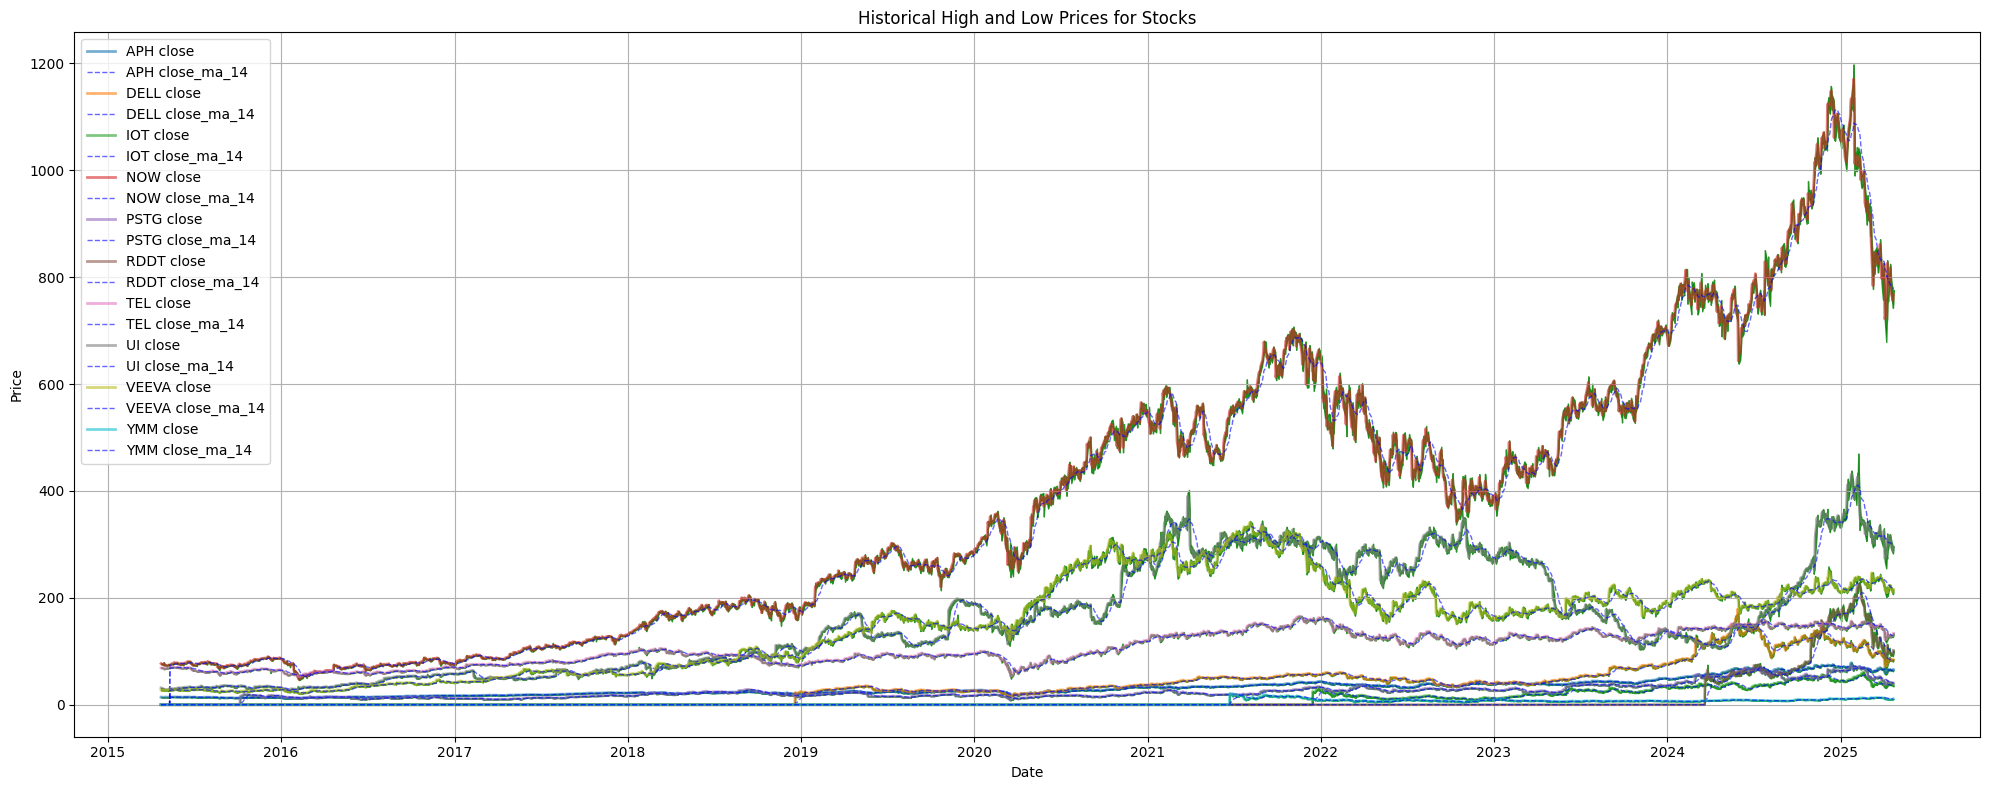

In [ ]:
import matplotlib.pyplot as plt

def plot_historical_high_low(stock_data):
    """
    Plots historical high and low prices for all stock symbols in the provided dictionary
    of DataFrames on a single graph.

    Args:
        stock_data (dict): A dictionary where keys are stock symbols and values are
                           Pandas DataFrames with 'date', 'high', and 'low' columns.
    """
    plt.figure(figsize=(20, 8))
    for symbol, df in stock_data.items():
        plt.plot(df['date'], df['close'] ,label=f'{symbol} close', alpha=0.6,  linewidth=2)
        plt.plot(df['date'], df['close_ma_14'], 'b--' ,label=f'{symbol} close_ma_14', alpha=0.6, linewidth=1)
        # plt.plot(df['date'], df['low'], label=f'{symbol} Low', alpha=0.6)
        plt.fill_between(df['date'], df['low'], df['high'], alpha=0.8, color='green')


    plt.title('Historical High and Low Prices for Stocks')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_historical_high_low(ma5_padded_stock_dfs)

In [8]:
from typing import Dict, Tuple
import os
import pickle

def train_test_split_dict(data: Dict[str, pd.DataFrame], test_size: float = 0.2) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    if not 0 <= test_size <= 1:
        raise ValueError("Input 'test_size' must be between 0 and 1.")

    train_data = {}
    test_data = {}
    for stock, df in data.items():
        # Calculate the split index
        split_index = int(len(df) * (1 - test_size))
        print(f"Split size {split_index}")
        train_df = df.iloc[:split_index].copy()
        test_df = df.iloc[split_index:].copy()

        train_data[stock] = train_df
        test_data[stock] = test_df

    return train_data, test_data

train_df, test_df = train_test_split_dict(ma5_padded_stock_dfs, test_size=0.2)



Split size 2012
Split size 2012
Split size 2012
Split size 2012
Split size 2012
Split size 2012
Split size 2012
Split size 2012
Split size 2012
Split size 2012


In [9]:
def save_dict_to_pickle(data_dict: Dict, filename: str, output_dir: str = ".") -> None:
    # don't think  this is useful at all, will remove later
    if not os.path.exists(output_dir):
        try:
            os.makedirs(output_dir)
        except OSError as e:
            raise OSError(f"Error creating output directory '{output_dir}': {e}")

    file_path = os.path.join(output_dir, f"{filename}.pkl")
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data_dict, f)
        print(f"Saved data to {file_path}")
    except Exception as e:
        raise Exception(f"Error saving to pickle file: {e}")

DIR = "./techLargCapStock"
save_dict_to_pickle(train_df, "train_df", output_dir=DIR)
save_dict_to_pickle(test_df, "test_df", output_dir=DIR)

Saved data to ./techLargCapStock\train_df.pkl
Saved data to ./techLargCapStock\test_df.pkl
